# Recognizing Hand-Written Characters using Tensorflow


*   Wooseok Kim
*   James Schallert



# Setting Google Account / Google Drive 

When we run below code, it takes so long. Thus, we decide to use Google CoLab to save much time because Google CoLab offers decent GPU.

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131304 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.3-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.3-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=ht

Connecting Google Account

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

Connecting Google Drive

In [0]:
!ls -ltr

total 12
drwxr-xr-x 1 root root 4096 Apr  4 20:20 sample_data
-rw-r--r-- 1 root root 2494 Apr 26 00:52 adc.json
drwxr-xr-x 2 root root 4096 Apr 26 00:52 drive


In [0]:
cd drive

/content/drive


In [0]:
cd emnist

/content/drive/emnist


In [0]:
!ls -ltr

total 778000
-rw-r--r-- 1 root root  36454802 Apr 25 00:06 emnist-balanced-test.csv
-rw-r--r-- 1 root root 218619475 Apr 25 00:08 emnist-balanced-train.csv
-rw-r--r-- 1 root root  77362729 Apr 25 00:09 emnist-digits-test.csv
-rw-r--r-- 1 root root 464090839 Apr 25 00:15 emnist-digits-train.csv
drwxr-xr-x 2 root root      4096 Apr 25 01:38 MNIST_data
-rw-r--r-- 1 root root     19697 Apr 25 03:23 ensemble.ipynb
-rw-r--r-- 1 root root    118367 Apr 26 00:53 MachineLearning.ipynb


# Data


*   https://www.kaggle.com/crawford/emnist



# Softmax

## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)





*   Import libraries
*   Importing training data set and test data set using Pandas



In [0]:
# Number of Train
numTrain = len(train)
print('numTrain: ', numTrain)
# Number of Test
numTest = len(test)
print('numTest: ', numTest)
# Number of Classes
numClasses = len(train[0].unique())
print('numClasses: ', numClasses)

numTrain:  112800
numTest:  18800
numClasses:  47


We check how many training data set and test data set there are. Also, we are able to figure out how many different output there are. If we use emnist data set, there are 47 outputs including 10 digits, 26 letters, and 11 capital letters. If we use eMNIST digit data set, the number of classes is 10 because of only 10 digits.

In [0]:
train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]



*   train_data: Training data set without labels
*   train_labels: Results of training data set
*   test_data: Test data set without labels
*   test_labels: Results of test data set



In [0]:
# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)

Use one-hot encoding

*  Reference


>* http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
>* https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html





In [0]:
train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values

Training data and test data, which categorical variables are converted by one-hot encoding, are overwritten

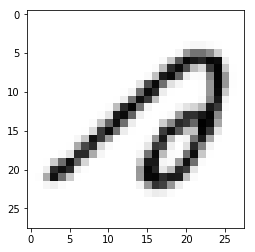

In [0]:
rand = random.randint(0, numTrain - 1)


plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()

A training data randomly chosen are displayed.

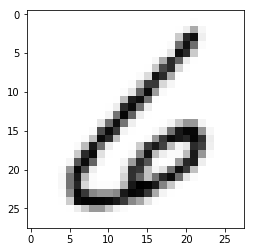

In [0]:
def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255


plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()

A training data which are randomly selected should be roated

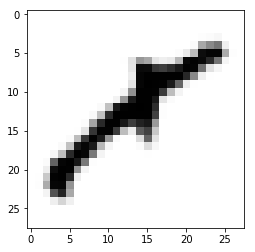

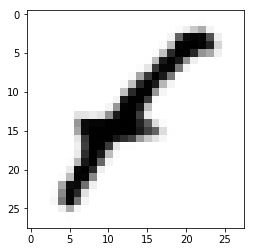

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values
#del train, test


rand = random.randint(0, numTrain - 1)


plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()


def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255


plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()



## Algorithm

In [0]:
tf.set_random_seed(777)  # for reproducibility


tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

A given data have 28*28 image. So we need 784. Also, the data we are currently using has 47 classes, which includes 10 digits (0~9), 26 letters, and 11 capital letters.

tf.placeholder(tf.float32, [None, 784]): In the code, none means we can give the data we want

![alt text](http://1.bp.blogspot.com/-aluMK8npLy0/VSoWDBNNblI/AAAAAAAABc8/XC1sy_3rsjw/s1600/MNIST1.png)

In [0]:
W = tf.Variable(tf.random_normal([784, numClasses]))
b = tf.Variable(tf.random_normal([numClasses]))

# Hypothesis (using softmax)
hypothesis = tf.nn.softmax(tf.matmul(X, W) + b)

Instructions for updating:
Colocations handled automatically by placer.


* W = tf.Variable(tf.random_normal([784, numClasses])): Input: 784, Output: numClasses, which indicates 47
* b = tf.Variable(tf.random_normal([numClasses])): Y size

Multinomial Classfication
$$
W = 
\begin{bmatrix}
    w_{11} & w_{12} & \dots & w_{1n} \\
    w_{21} & w_{22} & \dots & w_{2n} \\
    \vdots & \vdots & \ddots & \vdots \\
    w_{n1} & w_{n2} & \dots & w_{nn}
\end{bmatrix}
$$

$$
X = 
\begin{bmatrix}
    x_{1} \\
    x_{2} \\
    \vdots \\
    x_{n}
\end{bmatrix}
$$

Softmax
$$
S(y_i) = \frac{e^y_i} {\sum_j e^y_i}
$$

In sum, let's suppose y = XW
$$
XW = y  => \frac{e^y_i} {\sum_j e^y_i} => Probabilities
$$

This is Softmax on Tensorflow. 
softmax(tf.matmul(X, W) + b).
So, tf.nn.softmax computes softmax activations. We can say that 
$$
softmax = \frac{exp(logits)} {reduceSum(exp(logits), dim)}
$$

$$
cost(W) = -\frac {1} {m} \sum ylog(H(x)) + (1-y)log(1-H(x)) 
$$

In [0]:
cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))

$$
W = W -\alpha \frac{\partial}{\partial W} cost(W)
$$

In [0]:
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

Instructions for updating:
Use tf.cast instead.


In [0]:
# Test model
is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

* is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1)): Hypothesis value and Y value are compared
* accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32)): Calculate average value of is_correct. This is accuracy

In [0]:
# parameters
num_epochs = 20
batch_size = 100
num_iterations = int( numTrain / batch_size)



*   epoch = one forward pass and one backward pass of all the training examples
*   batch size = Number of training examples in one forward/backward pass. The higher the batch size is, the more memory space you'll need is
*  Number of iterations = number of passes, each pass using batch size number of examples. To be clear, one pass = one forward pass + one backward pass (we do not count the forward pass and backward pass as two different passes).
[5]


In [0]:
batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]

Training data can read 100 data at once.

In [0]:
_, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})

Calculate cost value using Optimization algorithm

In [0]:
# Test the model using test sets
    print(
        "Accuracy: ",
        accuracy.eval(
            session=sess, feed_dict={X: test_data, Y: test_labels}
        ),
    )

We use test data set which we haven't used before. So we evaluate test data set. Finally, we can calculate accuracy.

In [0]:
# Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

1. Get Random value
2. Read one of test labels using argmax because we used one-hot encoding
3. For prediction, we will run hypothesis. And then, we will get the image which are the same as hypothesis. 

Epoch: 0001, Cost: 7.831361669
Epoch: 0002, Cost: 3.635979679
Epoch: 0003, Cost: 2.910056583
Epoch: 0004, Cost: 2.549824970
Epoch: 0005, Cost: 2.325167478
Epoch: 0006, Cost: 2.168853015
Epoch: 0007, Cost: 2.052359234
Epoch: 0008, Cost: 1.961268801
Epoch: 0009, Cost: 1.887505654
Epoch: 0010, Cost: 1.826184638
Epoch: 0011, Cost: 1.774160550
Epoch: 0012, Cost: 1.729304836
Epoch: 0013, Cost: 1.690116639
Epoch: 0014, Cost: 1.655501113
Epoch: 0015, Cost: 1.624637229
Epoch: 0016, Cost: 1.596895715
Epoch: 0017, Cost: 1.571785485
Epoch: 0018, Cost: 1.548917508
Epoch: 0019, Cost: 1.527979174
Epoch: 0020, Cost: 1.508715988
Learning finished
Accuracy:  0.6129255
Label:  [24]
Prediction:  [0]


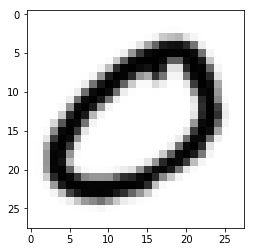

In [0]:
with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test the model using test sets
    print(
        "Accuracy: ",
        accuracy.eval(
            session=sess, feed_dict={X: test_data, Y: test_labels}
        ),
    )

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

## Code

### Alphabet / Digits

Epoch: 0001, Cost: 7.811212356
Epoch: 0002, Cost: 3.577890929
Epoch: 0003, Cost: 2.874251862
Epoch: 0004, Cost: 2.526106676
Epoch: 0005, Cost: 2.309650495
Epoch: 0006, Cost: 2.159337446
Epoch: 0007, Cost: 2.047290485
Epoch: 0008, Cost: 1.959520055
Epoch: 0009, Cost: 1.888236626
Epoch: 0010, Cost: 1.828750604
Epoch: 0011, Cost: 1.778055745
Epoch: 0012, Cost: 1.734127743
Epoch: 0013, Cost: 1.695548977
Epoch: 0014, Cost: 1.661293361
Epoch: 0015, Cost: 1.630596669
Epoch: 0016, Cost: 1.602875596
Epoch: 0017, Cost: 1.577675840
Epoch: 0018, Cost: 1.554637091
Epoch: 0019, Cost: 1.533469000
Epoch: 0020, Cost: 1.513934543
Learning finished
Accuracy:  0.6085106
Label:  [36]
Prediction:  [35]


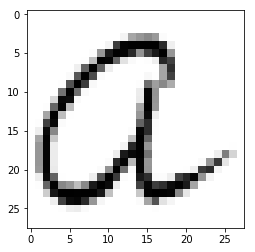

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

W = tf.Variable(tf.random_normal([784, numClasses]))
b = tf.Variable(tf.random_normal([numClasses]))

# Hypothesis (using softmax)
hypothesis = tf.nn.softmax(tf.matmul(X, W) + b)

cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))
train = tf.train.GradientDescentOptimizer(learning_rate=0.1).minimize(cost)

# Test model
is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# parameters
num_epochs = 20
batch_size = 100
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test the model using test sets
    print(
        "Accuracy: ",
        accuracy.eval(
            session=sess, feed_dict={X: test_data, Y: test_labels}
        ),
    )

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()


### Digits

Epoch: 0001, Cost: 12.294879703
Epoch: 0002, Cost: 7.675846588
Epoch: 0003, Cost: 5.530997338
Epoch: 0004, Cost: 4.266942058
Epoch: 0005, Cost: 3.466805372
Epoch: 0006, Cost: 2.930163783
Epoch: 0007, Cost: 2.553369329
Epoch: 0008, Cost: 2.277840718
Epoch: 0009, Cost: 2.068908990
Epoch: 0010, Cost: 1.905354305
Epoch: 0011, Cost: 1.773776403
Epoch: 0012, Cost: 1.665476663
Epoch: 0013, Cost: 1.574621240
Epoch: 0014, Cost: 1.497164249
Epoch: 0015, Cost: 1.430218704
Epoch: 0016, Cost: 1.371676122
Epoch: 0017, Cost: 1.319963597
Epoch: 0018, Cost: 1.273884969
Epoch: 0019, Cost: 1.232514620
Epoch: 0020, Cost: 1.195125107
Learning finished
Accuracy:  0.7697
Label:  [2]
Prediction:  [6]


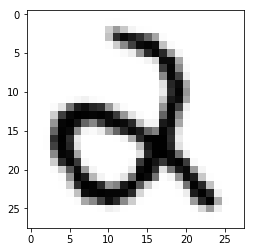

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


#train = pd.read_csv('emnist-balanced-train.csv', header=None)
train = pd.read_csv('emnist-digits-train.csv', header=None)

#test = pd.read_csv('emnist-balanced-test.csv', header=None)
test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

W = tf.Variable(tf.random_normal([784, numClasses]))
b = tf.Variable(tf.random_normal([numClasses]))

# Hypothesis (using softmax)
hypothesis = tf.nn.softmax(tf.matmul(X, W) + b)

cost = tf.reduce_mean(-tf.reduce_sum(Y * tf.log(hypothesis), axis=1))
train = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cost)

# Test model
is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

# parameters
num_epochs = 20
batch_size = 100
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test the model using test sets
    print(
        "Accuracy: ",
        accuracy.eval(
            session=sess, feed_dict={X: test_data, Y: test_labels}
        ),
    )

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()



# Neural Network

## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

The process of importing training data set and test data set is the same as softmax algorithm above

## Algorithm

In [0]:
# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

W1 = tf.Variable(tf.random_normal([784, 512]))
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([512, 512]))
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.Variable(tf.random_normal([512, 512]))
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.Variable(tf.random_normal([512, numClasses]))
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

![alt text](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

The figure[2] shows a regular 3-layer Neural Network. For the project, we are using 4-layer neural network. In other words, input layer in the code above is placeholders of X and Y. Input layer, which is a placeholder of X, is 784 because image size is 28*28. Output is 47, Y placeholder.

We have 3 hidden layers. First, hidden layer 1 (W1) has 784 inputs and 512 outputs. Hidden layers 2 and 3 have 512 inputs and 512 outpus. Since the output of hidden layer 1 is 512, we should have 512 inputs in hidden layer 2. Finally, we will get 47 outputs including 10 digits, 26 letters, and 11 capital letters. We use ReLU to calculate each layer.


![alt text](http://www.cs.albany.edu/~wooseok/536/NN.png)

ReLU: Rectified Linear Unit [4]

![alt text](https://cdn-images-1.medium.com/max/1600/1*XxxiA0jJvPrHEJHD4z893g.png)

In [0]:
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))

Computes softmax cross entropy between hypothesis(logits) and outputs(Y)

In [0]:
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In softmax algoritm, we use GradientDescentOptimizer in order for train. However, in neural network, we use AdamOptimizer. 

Here's interesting comparison in terms of optimization. The below site compares below optimazation algorithms


*   SGD
*   Momentum
*   NAG
*   Adagrad
*   Adadelta
*   RMSprop

http://www.denizyuret.com/2015/03/alec-radfords-animations-for.html


A reason why we use AdamOptimizer is that Adam shows the best optimization performance[3].

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/05/Comparison-of-Adam-to-Other-Optimization-Algorithms-Training-a-Multilayer-Perceptron.png)

Tensorflow offers Adam optimization library. So we can use easily the adam optimization algorithm. 
https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer

Lastly, we will train and evaluate our training using accuracy. The code is the same as Softmax algorithm

## Code

### Alphabet / Digits

numTrain:  112800
Epoch: 0001, Cost: 8642.529711351
Epoch: 0002, Cost: 2481.713991206
Epoch: 0003, Cost: 1461.960102920
Epoch: 0004, Cost: 983.205817202
Epoch: 0005, Cost: 699.275430531
Epoch: 0006, Cost: 514.055722013
Epoch: 0007, Cost: 382.135182009
Epoch: 0008, Cost: 290.110750185
Epoch: 0009, Cost: 223.293022807
Epoch: 0010, Cost: 173.172536803
Epoch: 0011, Cost: 138.131260886
Epoch: 0012, Cost: 109.862700687
Epoch: 0013, Cost: 90.336773301
Epoch: 0014, Cost: 74.091697410
Epoch: 0015, Cost: 63.775216297
Learning finished
Accuracy:  0.6993085
Label:  [0]
Prediction:  [24]


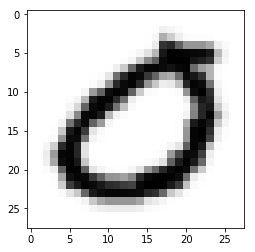

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])


W1 = tf.Variable(tf.random_normal([784, 512]))
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([512, 512]))
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.Variable(tf.random_normal([512, 512]))
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.Variable(tf.random_normal([512, numClasses]))
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels}))

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()


### Digits

numTrain:  240000
Epoch: 0001, Cost: 1254.097743122
Epoch: 0002, Cost: 246.871940774
Epoch: 0003, Cost: 137.709690004
Epoch: 0004, Cost: 86.881786227
Epoch: 0005, Cost: 59.710167026
Epoch: 0006, Cost: 44.622771997
Epoch: 0007, Cost: 35.687775417
Epoch: 0008, Cost: 27.622199425
Epoch: 0009, Cost: 24.814995090
Epoch: 0010, Cost: 21.613631717
Epoch: 0011, Cost: 19.230210329
Epoch: 0012, Cost: 17.108183406
Epoch: 0013, Cost: 15.746177453
Epoch: 0014, Cost: 14.488535248
Epoch: 0015, Cost: 13.864103281
Learning finished
Accuracy:  0.9823
Label:  [8]
Prediction:  [8]


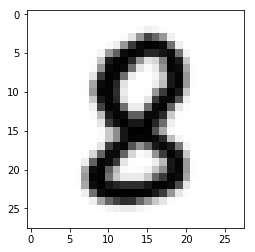

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


#train = pd.read_csv('emnist-balanced-train.csv', header=None)
train = pd.read_csv('emnist-digits-train.csv', header=None)

#test = pd.read_csv('emnist-balanced-test.csv', header=None)
test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])


W1 = tf.Variable(tf.random_normal([784, 512]))
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.Variable(tf.random_normal([512, 512]))
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.Variable(tf.random_normal([512, 512]))
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.Variable(tf.random_normal([512, numClasses]))
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels}))

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()



# Xavier Initialization

## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

The process of importing training data set and test data set is the same as softmax algorithm above. The initial value at first is very important to train the data set. That is, we should make sure the weights are just right, not too small, and not too big.

## Algorithm

In [0]:
# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])


# weights & bias for nn layers
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

Basic algorithm is the same as Neural Network above. A difference between Xavier algorithm  and Neural Network is an initialization value [6].  Input and output are randomly provided like below.

In [0]:
np.random.randn(input, output)/np.sqrt(input)

Google implemented prettytensor for Xavier initialization[7]. However, fortunately, tensorflow offers Xavier initialization library. So we use the library in hidden layer 1, 2, and 3.

In [0]:
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())

Lastly, we use identical cost and Adam optimization like neural networks and then train and evaluate our training using accuracy. The code is the same as above.

Cost values of Xavier are much lower than cost values of neural networks

## Code

### Alphabet / Digits


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

numTrain:  112800
Epoch: 0001, Cost: 0.922173137
Epoch: 0002, Cost: 0.501473968
Epoch: 0003, Cost: 0.411888543
Epoch: 0004, Cost: 0.357318249
Epoch: 0005, Cost: 0.319102287
Epoch: 0006, Cost: 0.288661301
Epoch: 0007, Cost: 0.262170818
Epoch: 0008, Cost: 0.242621696
Epoch: 0009, Cost: 0.229773155
Epoch: 0010, Cost: 0.212708886
Epoch: 0011, Cost: 0.199395352
Epoch: 0012, Cost: 0.196674012
Epoch: 0013, Cost: 0.183474308
Epoch: 0014, Cost: 0.173996904
Epoch: 0015, Cost: 0.170004412
Learning finished
Accuracy:  0.8368085
Label:  [6]
Prediction:  [6]


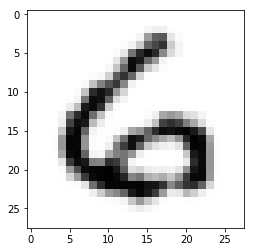

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])


# weights & bias for nn layers
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels}))
    

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

### Digits

numTrain:  240000
Epoch: 0001, Cost: 0.112610524
Epoch: 0002, Cost: 0.047038741
Epoch: 0003, Cost: 0.035235770
Epoch: 0004, Cost: 0.028168916
Epoch: 0005, Cost: 0.023147189
Epoch: 0006, Cost: 0.020137726
Epoch: 0007, Cost: 0.018170127
Epoch: 0008, Cost: 0.016829032
Epoch: 0009, Cost: 0.015006357
Epoch: 0010, Cost: 0.014536648
Epoch: 0011, Cost: 0.013235325
Epoch: 0012, Cost: 0.012501067
Epoch: 0013, Cost: 0.012648829
Epoch: 0014, Cost: 0.011626684
Epoch: 0015, Cost: 0.010933093
Learning finished
Accuracy:  0.988775
Label:  [8]
Prediction:  [8]


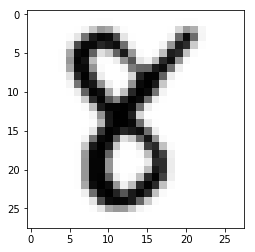

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


#train = pd.read_csv('emnist-balanced-train.csv', header=None)
train = pd.read_csv('emnist-digits-train.csv', header=None)

#test = pd.read_csv('emnist-balanced-test.csv', header=None)
test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])


# weights & bias for nn layers
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)

W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)

W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)


# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels}))
    

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1]}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

# Dropout

## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

The process of importing training data set and test data set is the same as above

## Algorithm

In [0]:
# dropout (keep_prob) rate
keep_prob = tf.placeholder(tf.float32)

# weights & bias for nn layers
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

We use dropout like below[8]. 

![alt text](https://cdn-images-1.medium.com/max/1600/1*tMAwd9AC4f8YFW5RiMUNvA.png)


Figure (a) shows general neural networks. Figure (b) indicates dropout which means that nodes are randomly disconnected. So, we should set randomly some neurons to zero in the forword pass. This avoids overfitting because networks can memorize training data set while training. We use dropout when we train data set. However, when we test data set, we should not apply dropout to the networks. If we use dropout during the test, we can't evaluate our training dataset well.

In [0]:
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

In order to implement dropout, we can add only one line due to tensorflow library. In the code, input is L1/L2/L3 and output is also L1/L2/L3. keep_prob means how much networks keep. According to what we study, 50%~70% of networks are kept while training.  

### Training

Training code is very similar to neural networks and Xavier except for keep_prob. Since we use dropout, we should add keep_prob when we train and test data set.

In [0]:
_, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})

We would like to keep 70% of networks while training. Therefore, keep_prob: 0.7 in the code above during training. 

### Testing

Without keep_prob, the code is almost identical with neural networks and Xavier.

In [0]:
# Test the model using test sets
print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels, keep_prob: 1}))

As we discussed above, we need to keep 100% of networks while testing even if we apply dropout during training. Therefore, keep_prob: 1 which means that we will not drop any networks.

## Code

### Alphabet/Digits

numTrain:  112800
Epoch: 0001, Cost: 1.251659688
Epoch: 0002, Cost: 0.728741870
Epoch: 0003, Cost: 0.641459946
Epoch: 0004, Cost: 0.590681597
Epoch: 0005, Cost: 0.561483818
Epoch: 0006, Cost: 0.539457501
Epoch: 0007, Cost: 0.522869468
Epoch: 0008, Cost: 0.505910995
Epoch: 0009, Cost: 0.499571343
Epoch: 0010, Cost: 0.490593512
Epoch: 0011, Cost: 0.480654343
Epoch: 0012, Cost: 0.479461333
Epoch: 0013, Cost: 0.472976663
Epoch: 0014, Cost: 0.461963027
Epoch: 0015, Cost: 0.455598501
Learning finished
Accuracy:  0.84957445
Label:  [3]
Prediction:  [3]


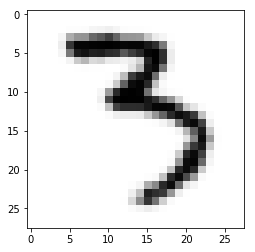

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# weights & bias for nn layers
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)



# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels, keep_prob: 1}))
    

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1], keep_prob: 1}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

### Digits

numTrain:  240000
Epoch: 0001, Cost: 0.175710808
Epoch: 0002, Cost: 0.081280281
Epoch: 0003, Cost: 0.067423555
Epoch: 0004, Cost: 0.059984454
Epoch: 0005, Cost: 0.056014791
Epoch: 0006, Cost: 0.051717673
Epoch: 0007, Cost: 0.050206302
Epoch: 0008, Cost: 0.046855801
Epoch: 0009, Cost: 0.044953876
Epoch: 0010, Cost: 0.043244649
Epoch: 0011, Cost: 0.044239188
Epoch: 0012, Cost: 0.043146146
Epoch: 0013, Cost: 0.040557425
Epoch: 0014, Cost: 0.040846657
Epoch: 0015, Cost: 0.040241697
Learning finished
Accuracy:  0.990575
Label:  [0]
Prediction:  [0]


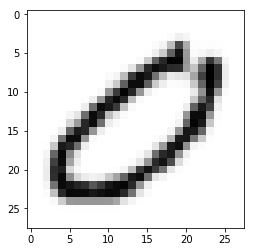

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


#train = pd.read_csv('emnist-balanced-train.csv', header=None)
train = pd.read_csv('emnist-digits-train.csv', header=None)

#test = pd.read_csv('emnist-balanced-test.csv', header=None)
test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
	train_data[rand].reshape([28, 28]), 
	cmap='Greys'
	)
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# weights & bias for nn layers
W1 = tf.get_variable("W1", shape=[784, 512], initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]))
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

W2 = tf.get_variable("W2", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable("W3", shape=[512, 512], initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

W4 = tf.get_variable("W4", shape=[512, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([numClasses]))
hypothesis = tf.matmul(L3, W4) + b4

# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)



# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels, keep_prob: 1}))
    

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(hypothesis, 1), feed_dict={X: test_data[r : r + 1], keep_prob: 1}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

# Convolutional Neural Networks (CNN)

## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

The process of importing training data set and test data set is the same as softmax algorithm above

## Algorithm

![alt text](http://cs231n.github.io/assets/cnn/convnet.jpeg)

* Input: Our input is 28x28 image. 
* CONV layer: The layer will compute the output which are connected to local regions in the input
* RELU layer: We use ReLU in order to apply an elementwise activation function
* POOL layer: The layer will make a smaller image than original image by performing a downsampling operation
* FC layer: FC stands for Fully Connected. The layer will compute the classes
[2]

We use below CNN structure [9]
![alt text](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)


### Input layer

In [0]:
# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])

In [0]:
X_img = tf.reshape(X, [-1, 28, 28, 1])

* -1 indicates tensorflow decides the number of images.
* Image size is 28 x 28. 
* color is 1. In other words, it is black and white. 

### Convolutional layer1

In [0]:
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))

A filter size is 3x3 and color is the same as image size. And we will use 32 filters, which are different images. 

In [0]:
# (28, 28, 32)
tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')

1. The filter, which is 1x1, will move to 1 step. That is, strides tells how many steps can move at once.
2. padding='SAME': Input image size and output image size are identical regardless of image size.
3. After convolution 2d is done, image size is 28x28 like original image size. 

In [0]:
L1 = tf.nn.relu(L1)

We use ReLU after convoluational layer

### Pooling layer 1

In [0]:
# (14, 14, 32)
tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

Input is L1 which is previous data set. Kernel size is 2x2 and filter size is also 2x2. Since strides is 2x2, original images will decrease. For instance, the image is 28x28 and modified image is 14x14 due to the stride, which is the filter. So, we will have 32 different images after max-pooling.

In [0]:
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

Last step is to use dropout

### Convolutional layer 2

In [0]:
# L2 Img Input shape=(n, 14, 14, 32)
# Conv = (n, 14, 14, 64)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)

Since we have 32 different images after pooling layer 1, we should use 32 colors as an input. Also, we increases the number of filters 

### Pooling layer 2

In [0]:
# Pool = (n, 7, 7, 64)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

It is the same as pooling layer 1

### Convolutional layer 3

In [0]:
# L3 Img Input shape=(n, 7, 7, 64)
# Conv = (n, 7, 7, 128)
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)

Like convolutional layer 3, after pooling layer 2, there are 64 different images. So, our input should be 64 and we increases the number of filters.

### Pooling layer 3


In [0]:
# Pool = (n, 4, 4, 128)
L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)


It is the same as pooling layer 2

### Locally Connected layer

In [0]:
# Reshape = (n, 4 * 4 * 128) 
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])

Before our image gets into fully connected layer, we need to reshape our image. In convolutional layer 3, we have 4x4 and 128 different images after pooling. The reason why there are 128 different images is the number of filters in convolutional layer 3. In order to reshape array size, we should multiply 4x4x128. 

### Fully Connected layer 1

In [0]:
W4 = tf.get_variable("W4", shape=[128*4*4, 625], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4)+b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

This is first fully connected layer. Output of array shape will be 625. And then, we use ReLU and dropout such as convolutional layer and pooling layer.

### Fully Connected layer 2

In [0]:
W5 = tf.get_variable("W5", shape=[625, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([numClasses]))
logits = tf.matmul(L4, W5) + b5

Lastly, our real output should be the number of classes, which is 47.

### Train

In [0]:
_, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})

Like we discusses above dropout algorithm, when we train data set, we would like to keep 70% of networks.

### Test

In [0]:
sess.run(tf.argmax(logits, 1), feed_dict={X: test_data[r : r + 1], keep_prob: 1})

However, we need to use all the networks when we test data set.

## Code

### Alphabet/Digits

numTrain:  112800
Epoch: 0001, Cost: 1.059922579
Epoch: 0002, Cost: 0.515719846
Epoch: 0003, Cost: 0.449088449
Epoch: 0004, Cost: 0.412468898
Epoch: 0005, Cost: 0.390916076
Epoch: 0006, Cost: 0.373371925
Epoch: 0007, Cost: 0.359837109
Epoch: 0008, Cost: 0.349027968
Epoch: 0009, Cost: 0.336722072
Epoch: 0010, Cost: 0.331467421
Epoch: 0011, Cost: 0.325443666
Epoch: 0012, Cost: 0.317864727
Epoch: 0013, Cost: 0.311824368
Epoch: 0014, Cost: 0.309578560
Epoch: 0015, Cost: 0.303445078
Learning finished
Accuracy:  0.89090425
Label:  [37]
Prediction:  [37]


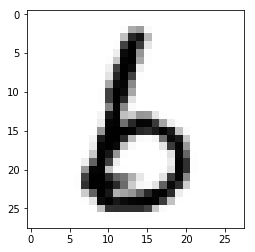

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])
X_img = tf.reshape(X, [-1, 28, 28, 1])

# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# L1 Img Input shape=(n, 28, 28, 1)
# Conv = (n, 28, 28, 32)
# Pool = (n, 14, 14, 32)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

# L2 Img Input shape=(n, 14, 14, 32)
# Conv = (n, 14, 14, 64)
# Pool = (n, 7, 7, 64)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

# L3 Img Input shape=(n, 7, 7, 64)
# Conv = (n, 7, 7, 128)
# Pool = (n, 4, 4, 128)
# Reshape = (n, 4 * 4 * 128) 
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])

# L4 Fully Connected (FC) 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128*4*4, 625], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4)+b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

# L5 Final Fully Connected (FC) 625 inputs -> numClasses outputs
W5 = tf.get_variable("W5", shape=[625, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([numClasses]))
logits = tf.matmul(L4, W5) + b5


# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)



# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels, keep_prob: 1}))
    

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(logits, 1), feed_dict={X: test_data[r : r + 1], keep_prob: 1}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

### Digits


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

numTrain:  240000
Epoch: 0001, Cost: 0.132140247
Epoch: 0002, Cost: 0.040341742
Epoch: 0003, Cost: 0.032980858
Epoch: 0004, Cost: 0.029762897
Epoch: 0005, Cost: 0.027134110
Epoch: 0006, Cost: 0.024512553
Epoch: 0007, Cost: 0.023280032
Epoch: 0008, Cost: 0.021658956
Epoch: 0009, Cost: 0.021289860
Epoch: 0010, Cost: 0.020385694
Epoch: 0011, Cost: 0.019163505
Epoch: 0012, Cost: 0.020146366
Epoch: 0013, Cost: 0.017946620
Epoch: 0014, Cost: 0.018162947
Epoch: 0015, Cost: 0.017307029
Learning finished
Accuracy:  0.996125
Label:  [2]
Prediction:  [2]


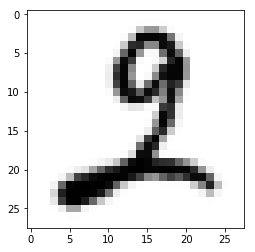

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


#train = pd.read_csv('emnist-balanced-train.csv', header=None)
train = pd.read_csv('emnist-digits-train.csv', header=None)

#test = pd.read_csv('emnist-balanced-test.csv', header=None)
test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

tf.set_random_seed(777)  # for reproducibility
tf.reset_default_graph()

# EMNIST data image of shape 28 * 28 = 784
X = tf.placeholder(tf.float32, [None, 784])
# 47 classes: 10 digits, 26 letters, and 11 capital letters 
Y = tf.placeholder(tf.float32, [None, numClasses])
X_img = tf.reshape(X, [-1, 28, 28, 1])

# dropout (keep_prob) rate  0.7 on training, but should be 1 for testing
keep_prob = tf.placeholder(tf.float32)

# L1 Img Input shape=(n, 28, 28, 1)
# Conv = (n, 28, 28, 32)
# Pool = (n, 14, 14, 32)
W1 = tf.Variable(tf.random_normal([3, 3, 1, 32], stddev=0.01))
L1 = tf.nn.conv2d(X_img, W1, strides=[1, 1, 1, 1], padding='SAME')
L1 = tf.nn.relu(L1)
L1 = tf.nn.max_pool(L1, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

# L2 Img Input shape=(n, 14, 14, 32)
# Conv = (n, 14, 14, 64)
# Pool = (n, 7, 7, 64)
W2 = tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.01))
L2 = tf.nn.conv2d(L1, W2, strides=[1, 1, 1, 1], padding='SAME')
L2 = tf.nn.relu(L2)
L2 = tf.nn.max_pool(L2, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

# L3 Img Input shape=(n, 7, 7, 64)
# Conv = (n, 7, 7, 128)
# Pool = (n, 4, 4, 128)
# Reshape = (n, 4 * 4 * 128) 
W3 = tf.Variable(tf.random_normal([3, 3, 64, 128], stddev=0.01))
L3 = tf.nn.conv2d(L2, W3, strides=[1, 1, 1, 1], padding='SAME')
L3 = tf.nn.relu(L3)
L3 = tf.nn.max_pool(L3, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)
L3_flat = tf.reshape(L3, [-1, 128 * 4 * 4])

# L4 Fully Connected (FC) 4x4x128 inputs -> 625 outputs
W4 = tf.get_variable("W4", shape=[128*4*4, 625], initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([625]))
L4 = tf.nn.relu(tf.matmul(L3_flat, W4)+b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

# L5 Final Fully Connected (FC) 625 inputs -> numClasses outputs
W5 = tf.get_variable("W5", shape=[625, numClasses], initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([numClasses]))
logits = tf.matmul(L4, W5) + b5


# cost & train
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=Y))
train = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)



# parameters
num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)

with tf.Session() as sess:
    # Initialize TensorFlow variables
    sess.run(tf.global_variables_initializer())
    # Training
    for epoch in range(num_epochs):
        avg_cost = 0

        for i in range(num_iterations):
            batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]
            _, cost_val = sess.run([train, cost], feed_dict={X: batch_xs, Y: batch_ys, keep_prob: 0.7})
            avg_cost += cost_val / num_iterations

        print("Epoch: {:04d}, Cost: {:.9f}".format(epoch + 1, avg_cost))

    print("Learning finished")

    # Test model
    is_correct = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))

    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(is_correct, tf.float32))

    # Test the model using test sets
    print("Accuracy: ", sess.run(accuracy, feed_dict={X: test_data, Y: test_labels, keep_prob: 1}))
    

    # Get Label and predict
    r = random.randint(0, numTest - 1)
    print("Label: ", sess.run(tf.argmax(test_labels[r : r + 1], 1)))
    print(
        "Prediction: ",
        sess.run(tf.argmax(logits, 1), feed_dict={X: test_data[r : r + 1], keep_prob: 1}),
    )

    plt.imshow(
        test_data[r : r + 1].reshape(28, 28),
        cmap="Greys",
        interpolation="nearest",
    )
    plt.show()

# Ensemble

## Load data

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255



The process of importing training data set and test data set is the same as softmax algorithm above

## Algorithm

In this algorith, we use tensorflow layer. So, we use tf.layers.conv2d instead of tf.nn.conv2d as an example. This is because we realize tensorflow layer is easier to use. 

![alt text](http://rasbt.github.io/mlxtend/user_guide/classifier/StackingClassifier_files/stackingclassification_overview.png)

* Classification models: We train several data set
> When new data are added
* Predictions: Each classes make each prediction value, which is accuracy
* Finally, predicted values are combined

### Convolutaional/Pooling layer 1

In [0]:
# Convolutional Layer 1 and Pooling Layer 1
conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)

tf.layers.conv2d
* input: An image 28x28
* filter: We use 32 filters.
* kernel_size: This is the filter size. We use 3x3 filter
* padding="SAME":  Input image size and output image size are identical regardless of image size.
* activation: We use ReLU

In [0]:
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], padding="SAME", strides=2)

tf.layers.max_pooling2d
* input: we use previous layer, which is conv1
* pool_size: We use 2x2 filter size. Since pool size is 2x2, original images will decrease. For instance, the image is 28x28 and modified image is 14x14 due to the stride, which is the filter. 
* strides: The number of steps to move forward at once

In [0]:
dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=self.training)

tf.layers.dropout
* input: We use previous pooling layer, which is pool1
* rate: We would like to keep 30% of networks to apply dropout
* training: Wether to either train or test. So, this is boolean value. If we are testing, dropout rate is automatically 1.

### Convolutional/Pooling layer 2

In [0]:
# Convolutional Layer 2 and Pooling Layer 2
conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], padding="SAME", strides=2)
dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)

It is the same as convolutional layer 1 and pooling layer 1. However, the number of filters is different

### Convolutional/Pooling layer 3

In [0]:
# Convolutional Layer 3 and Pooling Layer 3
conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], padding="SAME", strides=2)
dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=self.training)

It is the same as convolutional layer 2 and pooling layer 2. However, the number of filters is different

## Fully Connected layer

In [0]:
# Dense Layer with Relu
flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])

Before we get into the Fully Connected layer, we should reshape array size. In pooling layer3, there are 128 different images and the image size is 4*4. So, array shape should be 128x4x4. 

In [0]:
dense4 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=self.training)

We use tf.layers.dense in order for Fully Connected layer
* input: Reshaped array
* units: A number of outputs
* activation: We use ReLU

Dropout is the same as above

### Train

In [0]:
models = []
num_models = 4
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

We use 4 models. So we make 4 models.  

In [0]:
# Train each model
for m_idx, m in enumerate(models):
  c, _ = m.train(batch_xs, batch_ys)
  avg_cost_list[m_idx] += c / num_iterations

We train each models. This is a difference between CNN above and ensemble. avg_cost_list has each accuracy value of each models. 

### Test

In [0]:
# Test & accuracy
predictions = np.zeros([numTest, numClasses])
for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy:', m.get_accuracy(test_data, test_labels))
    p = m.predict(test_data)
    predictions += p

We make 47 arrays becaue of the number of outputs. Each prediction is added, which is predictions in the code. 

In [0]:
ensemble_correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct_prediction, tf.float32))

We compare prediction value with test label. And then, we can calculate the accuracy.

## Code

### Alphabet/Digits

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


train = pd.read_csv('emnist-balanced-train.csv', header=None)
#train = pd.read_csv('emnist/emnist-digits-train.csv', header=None)

test = pd.read_csv('emnist-balanced-test.csv', header=None)
#test = pd.read_csv('emnist/emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255



class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._runEnsemble()

    def _runEnsemble(self):
        with tf.variable_scope(self.name):
            self.training = tf.placeholder(tf.bool)

            # EMNIST data image of shape 28 * 28 = 784
            self.X = tf.placeholder(tf.float32, [None, 784])
            # 47 classes: 10 digits, 26 letters, and 11 capital letters
            self.Y = tf.placeholder(tf.float32, [None, numClasses])
            # Input Image
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])

            # Convolutional Layer 1 and Pooling Layer 1
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=self.training)

            # Convolutional Layer 2 and Pooling Layer 2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)

            # Convolutional Layer 3 and Pooling Layer 3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], padding="SAME", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=numClasses)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})

# initialize
sess = tf.Session()

models = []
num_models = 4
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

print('Learning Started!')

num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)


# Train
for epoch in range(num_epochs):
    avg_cost_list = np.zeros(len(models))
    for i in range(num_iterations):
        batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]

        # Train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            avg_cost_list[m_idx] += c / num_iterations

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', avg_cost_list)

print('Learning Finished!')


# Test & accuracy
predictions = np.zeros([numTest, numClasses])
for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy:', m.get_accuracy(test_data, test_labels))
    p = m.predict(test_data)
    predictions += p

ensemble_correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct_prediction, tf.float32))
print('Final accuracy:', sess.run(ensemble_accuracy))


Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Learning Started!
numTrain:  112800
Epoch: 0001 cost = [0.93694787 0.96545307 0.96958477 0.95645672]
Epoch: 0002 cost = [0.51001651 0.52268768 0.51578384 0.51749801]
Epoch: 0003 cost = [0.44954652 0.46018538 0.45869213 0.45723559]
Epoch: 0004 cost = [0.42094525 0.42600334 0.42507715 0.42196886]
Epoch: 0005 cost = [0.39802434 0.40422068 0.4024648  0.40161107]
Epoch: 0006 co

### Digits

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf


#train = pd.read_csv('emnist-balanced-train.csv', header=None)
train = pd.read_csv('emnist-digits-train.csv', header=None)

#test = pd.read_csv('emnist-balanced-test.csv', header=None)
test = pd.read_csv('emnist-digits-test.csv', header=None)

#train.head()

# Number of Train
numTrain = len(train)
# Number of Test
numTest = len(test)
# Number of Classes
numClasses = len(train[0].unique())
learning_rate = 0.001

train_data = train.iloc[:, 1:]
train_labels = train.iloc[:, 0]
test_data = test.iloc[:, 1:]
test_labels = test.iloc[:, 0]

# one-hot encoding
train_labels = pd.get_dummies(train_labels)
test_labels = pd.get_dummies(test_labels)
#train_labels.head()

train_data = train_data.values
train_labels = train_labels.values
test_data = test_data.values
test_labels = test_labels.values


rand = random.randint(0, numTrain - 1)

'''
plt.imshow(
    train_data[rand].reshape([28, 28]), 
    cmap='Greys'
    )
plt.show()
'''

def rotate(image):
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image.reshape([28 * 28])
train_data = np.apply_along_axis(rotate, 1, train_data)/255
test_data = np.apply_along_axis(rotate, 1, test_data)/255



class Model:

    def __init__(self, sess, name):
        self.sess = sess
        self.name = name
        self._runEnsemble()

    def _runEnsemble(self):
        with tf.variable_scope(self.name):
            self.training = tf.placeholder(tf.bool)

            # EMNIST data image of shape 28 * 28 = 784
            self.X = tf.placeholder(tf.float32, [None, 784])
            # 47 classes: 10 digits, 26 letters, and 11 capital letters
            self.Y = tf.placeholder(tf.float32, [None, numClasses])
            # Input Image
            X_img = tf.reshape(self.X, [-1, 28, 28, 1])

            # Convolutional Layer 1 and Pooling Layer 1
            conv1 = tf.layers.conv2d(inputs=X_img, filters=32, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], padding="SAME", strides=2)
            dropout1 = tf.layers.dropout(inputs=pool1, rate=0.3, training=self.training)

            # Convolutional Layer 2 and Pooling Layer 2
            conv2 = tf.layers.conv2d(inputs=dropout1, filters=64, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], padding="SAME", strides=2)
            dropout2 = tf.layers.dropout(inputs=pool2, rate=0.3, training=self.training)

            # Convolutional Layer 3 and Pooling Layer 3
            conv3 = tf.layers.conv2d(inputs=dropout2, filters=128, kernel_size=[3, 3], padding="SAME", activation=tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], padding="SAME", strides=2)
            dropout3 = tf.layers.dropout(inputs=pool3, rate=0.3, training=self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs=dense4, rate=0.5, training=self.training)

            # Logits (no activation) Layer: L5 Final FC 625 inputs -> outputs
            self.logits = tf.layers.dense(inputs=dropout4, units=numClasses)

        # define cost/loss & optimizer
        self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.cost)

        correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def predict(self, x_test, training=False):
        return self.sess.run(self.logits, feed_dict={self.X: x_test, self.training: training})

    def get_accuracy(self, x_test, y_test, training=False):
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.training: training})

    def train(self, x_data, y_data, training=True):
        return self.sess.run([self.cost, self.optimizer], feed_dict={self.X: x_data, self.Y: y_data, self.training: training})

# initialize
sess = tf.Session()

models = []
num_models = 4
for m in range(num_models):
    models.append(Model(sess, "model" + str(m)))

sess.run(tf.global_variables_initializer())

print('Learning Started!')

num_epochs = 15
batch_size = 100
print('numTrain: ', numTrain)
num_iterations = int( numTrain / batch_size)


# Train
for epoch in range(num_epochs):
    avg_cost_list = np.zeros(len(models))
    for i in range(num_iterations):
        batch_xs, batch_ys = train_data[i * 100: (i + 1) * 100], train_labels[i * 100: (i + 1) * 100]

        # Train each model
        for m_idx, m in enumerate(models):
            c, _ = m.train(batch_xs, batch_ys)
            avg_cost_list[m_idx] += c / num_iterations

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', avg_cost_list)

print('Learning Finished!')


# Test & accuracy
predictions = np.zeros([numTest, numClasses])
for m_idx, m in enumerate(models):
    print(m_idx, 'Accuracy:', m.get_accuracy(test_data, test_labels))
    p = m.predict(test_data)
    predictions += p

ensemble_correct_prediction = tf.equal(tf.argmax(predictions, 1), tf.argmax(test_labels, 1))
ensemble_accuracy = tf.reduce_mean(tf.cast(ensemble_correct_prediction, tf.float32))
print('Final accuracy:', sess.run(ensemble_accuracy))



Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Learning Started!
numTrain:  240000
Epoch: 0001 cost = [0.10468324 0.10184871 0.10251109 0.10327382]
Epoch: 0002 cost = [0.03955471 0.03966181 0.04028189 0.03961207]
Epoch: 0003 cost = [0.03291164 0.03285973 0.03267252 0.03280353]
Epoch: 0004 cost = [0.02949152 0.02939486 0.02953999 0.02957595]
Epoch: 0005 cost = [0.02754066 0.02755699 0.02666415 0.02744095]
Epoch: 0006 co

# Summary

||Alphabet/Digits|Digits|
|--|:----------------|-------|
|Logistic Regression|0.6085106|0.7697|
|Neural Networks|0.6993085|0.9823|
|Xavier|0.8368085|0.988775|
|Dropout|0.84957445|0.990575|
|CNN|0.89090425|0.996125|
|Ensemble|0.89521277|0.997225|


# Reference


1.   Gregory Cohen, Saeed Afshar, Jonathan Tapson, and Andre ́ van Schaik, "EMNIST: an extension of MNIST to handwritten letters", March 2017
2.  http://cs231n.github.io/convolutional-networks/
3. Diederik P. Kingma, Jimmy Lei Ba, "ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION", ICLR 2015
4.  https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
5. https://stackoverflow.com/questions/4752626/epoch-vs-iteration-when-training-neural-networks
6. Xavier Glorot, Yoshua Bengio, "Understanding the difficulty of training deep feedforward neural networks", 2010
7. https://github.com/google/prettytensor/blob/a69f13998258165d6682a47a931108d974bab05e/prettytensor/layers.py
8. Nitish Srivastava, Geoffrey Hinton, Alex Krizhevsky, Ilya Sutskever, Ruslan Salakhutdinov, "Dropout: A Simple Way to Prevent Neural Networks from Overfiting", Journal of Machine Learning Research, May 2014
9. Shuo Yang, Ping Luo, Chen Change Loy, Kenneth W. Shu, Xiaoou Tang, "Deep Representation Learning with Target Coding", AAAI Conference on Artificial Intelligence, 2015
10. Tang, J., S. Alelyani, and H. Liu. "Data Classification: Algorithms and Applications." Data Mining and Knowledge Discovery Series, CRC Press (2015): pp. 498-500